### Predict next year results using previous year model

In [1]:
# Load Libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
import data_loader
import model_builder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
model_path = '/home/h6x/git_projects/overdose_modeling/SEResNet_15_channels/models/trained_models/se_restnet_2018_80_data.pth'

In [3]:
# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Create a new model instance
CONFIG_NAME = 50
model = model_builder.SEResNet(CONFIG_NAME).to(device)

In [5]:
# Load the saved model state dictionary
checkpoint = torch.load(model_path)

In [6]:
# Load the saved model weights
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
# Set the model to evaluation mode
model.eval()

SEResNet(
  (blocks): ModuleList(
    (0): ResNetBlock(
      (p): ConvBlock(
        (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (c1): ConvBlock(
        (c): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (c2): ConvBlock(
        (c): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (c3): ConvBlock(
        (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
      (seblock): SeBlock(
        (globpool): AdaptiveAvgPool2d(output_size=(1, 1))
        (fc1): Linea

In [8]:
# Create transforms for the new dataset
data_transform = transforms.Compose([
    transforms.ToTensor()
])

In [9]:
# Setup directories for the new dataset

# change 80.90,95 in both paths depending on the model used

# next year - 2020
# new_root_dir = "/home/h6x/git_projects/data_processing/processed_data/adjacency_pers_images_npy_county/2020/experimet_3/npy_combined"
# new_annotation_file_path = "/home/h6x/git_projects/data_processing/processed_data/adjacency_pers_images_npy_county/2020/experimet_3/annotations_2020_npy_2_classes_only_h0h1_80_percentile_all_data.csv"

#same year - 2018
new_root_dir = "/home/h6x/git_projects/data_processing/processed_data/adjacency_pers_images_npy_county/experimet_3/npy_combined"
new_annotation_file_path = "/home/h6x/git_projects/data_processing/processed_data/adjacency_pers_images_npy_county/experimet_3/annotations_2018_npy_2_classes_only_h0h1_80_percentile_all_data.csv"

In [10]:
all_data = pd.read_csv(new_annotation_file_path)

In [11]:
# get count of each class on the "OD_class" column
print(all_data['OD_class'].value_counts())

OD_class
0    2154
1     586
Name: count, dtype: int64


In [12]:
BATCH_SIZE = 64

In [13]:
# import the dataset
data_set = data_loader.data_loader_persistence_img(annotation_file_path=new_annotation_file_path, root_dir=new_root_dir, transform=data_transform)

In [14]:
# Get class names
class_names = data_set.get_class_names()

In [15]:
class_names

[0, 1]

In [16]:
import os
NUM_WORKERS = os.cpu_count()

In [17]:
# Turn images into data loaders
new_dataloader = DataLoader(
      data_set,
      batch_size=BATCH_SIZE,
      shuffle=False,
      num_workers=NUM_WORKERS,
      pin_memory=True,
  )

In [18]:
def predict_and_evaluate(model, dataloader, device):
    model.to(device)
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

In [19]:
# Make predictions and collect the ground truth labels
y_true, y_pred = predict_and_evaluate(model, new_dataloader, device)

/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [20]:
conf_matrix = confusion_matrix(y_true, y_pred)

In [21]:
# Function to calculate TPR and FPR for each class
def calculate_tpr_fpr(conf_matrix):
    num_classes = conf_matrix.shape[0]
    TPR = np.zeros(num_classes)
    FPR = np.zeros(num_classes)
    FNR = np.zeros(num_classes)
    
    for i in range(num_classes):
        TP = conf_matrix[i, i]
        FN = np.sum(conf_matrix[i, :]) - TP
        FP = np.sum(conf_matrix[:, i]) - TP
        TN = np.sum(conf_matrix) - (TP + FN + FP)
        
        TPR[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        FPR[i] = FP / (FP + TN) if (FP + TN) != 0 else 0
        FNR[i] = FN / (TP + FN) if (TP + FN) != 0 else 0
    
    return TPR, FPR, FNR

# Calculate TPR and FPR
TPR, FPR, FNR = calculate_tpr_fpr(conf_matrix)

# Print TPR and FPR for each class
for idx, class_name in enumerate(class_names):
    print(f"Class {class_name} - TPR: {TPR[idx]:.2f}, FPR: {FPR[idx]:.2f}, FNR: {FNR[idx]:.2f}")

Class 0 - TPR: 0.87, FPR: 0.50, FNR: 0.13
Class 1 - TPR: 0.50, FPR: 0.13, FNR: 0.50


In [22]:
import seaborn as sns

In [23]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    # plt.savefig('/home/h6x/git_projects/overdose_modeling/SEResNet_15_channels/plots/confusion_matrix_95_percentile_2020_prediction.png')

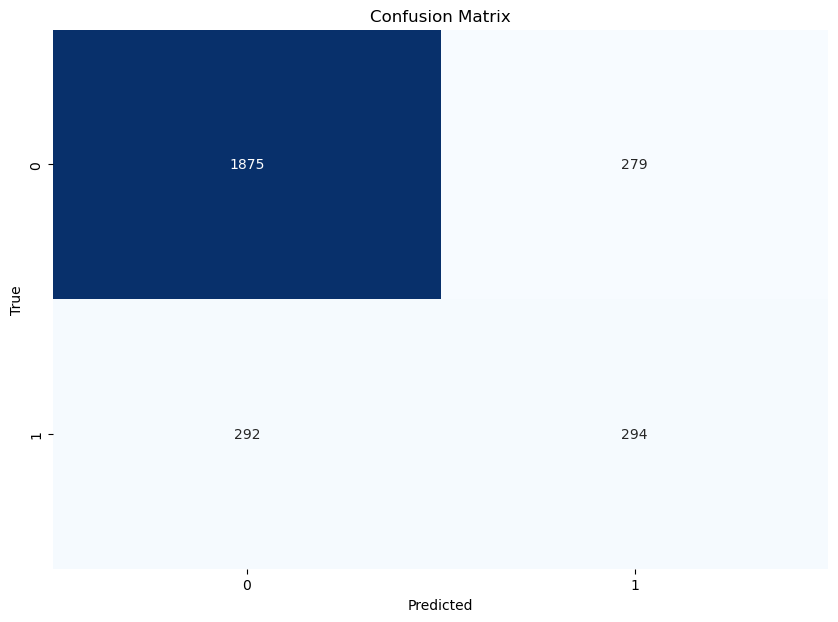

In [24]:
# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, class_names)